<a href="https://colab.research.google.com/github/SpaceXdaehan/Python/blob/main/ml02_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

* import module_name [as alias]
* from module_name import class_name, function_name, ...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn 패키지: 머신 러닝 알고리즘을 구현한 패키지.
from sklearn.neighbors import KNeighborsClassifier # 클래스
from sklearn.model_selection import train_test_split # 함수

# 분류 평가 지표 함수들
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# 스케일러
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 데이터셋 준비

수산시장(fish market) 데이터 셋, 물고기 종류(어종)과 물고기의 여러가지 특성들 (길이, 무게, 대각선 길이, ...)이 정리된 CSV 파일.

In [ ]:
# CSV파일 경로
fish_csv = 'https://github.com/JakeOh/20230228_itwill_java140_lab_python/raw/main/fish.csv'

In [ ]:
# CSV 파일을 읽어서 DataFrame을 생성.
fish_df = pd.read_csv(fish_csv)

In [ ]:
fish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   159 non-null    object 
 1   Weight    159 non-null    float64
 2   Length    159 non-null    float64
 3   Diagonal  159 non-null    float64
 4   Height    159 non-null    float64
 5   Width     159 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB


# 데이터 탐색(EDA: Exploratory Data Analysis)

## 카테고리 타입 변수 탐색

In [ ]:
fish_df.Species.unique() # 중복되지 않는 값을 찾음

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

In [ ]:
species_count = fish_df.Species.value_counts()
species_count

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

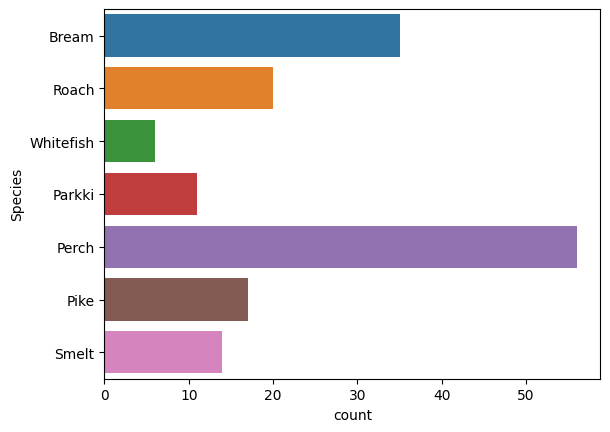

In [ ]:
sns.countplot(data=fish_df, y='Species')
plt.show()

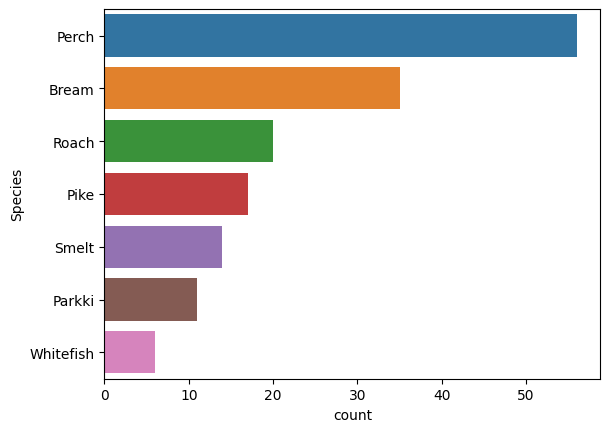

In [ ]:
sns.countplot(data=fish_df, y='Species', order=species_count.index)
plt.show()

# 숫자 타입 변수 탐색

In [ ]:
fish_df.describe()

,Weight,Length,Diagonal,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,28.415723,31.227044,8.970994,4.417486
std,357.978317,10.716328,11.610246,4.286208,1.685804
min,0.000000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,63.400000,68.000000,18.957000,8.142000


1x5 subplots을 생성하고, 숫자타입 변수(컬럼) 5개의 히스토그램을 그리세요.

In [ ]:
variables = fish_df.columns[1:] # 숫자 타입 컬럼(변수)들의 이름
print(variables)

Index(['Weight', 'Length', 'Diagonal', 'Height', 'Width'], dtype='object')


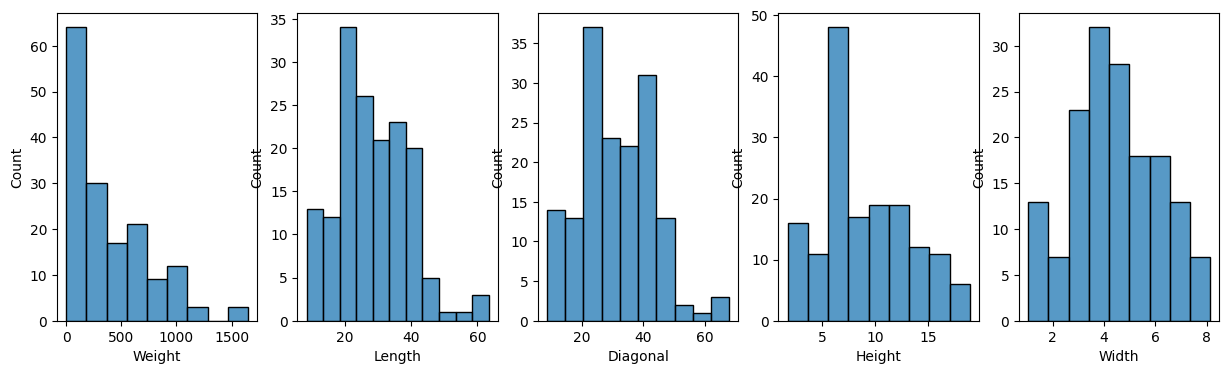

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(15, 4))

for i, v in enumerate(variables):
  sns.histplot(data=fish_df, x=v, ax=ax[i])
plt.show()

1x5 subplots을 생성하고, 숫자타입 변수들의 box plot을 그리세요.

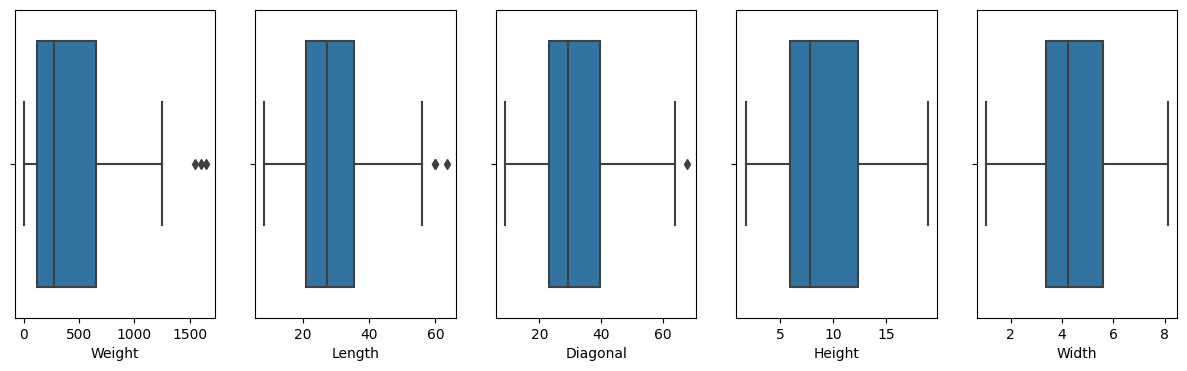

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(15, 4))

for i, v in enumerate(variables):
  sns.boxplot(data=fish_df, x=v, ax=ax[i])
plt.show()

In [ ]:
fish_df.corr(numeric_only=True)  # Pearson 상관 계수

,Weight,Length,Diagonal,Height,Width
Weight,1.000000,0.918618,0.923044,0.724345,0.886507
Length,0.918618,1.000000,0.994103,0.640441,0.873547
Diagonal,0.923044,0.994103,1.000000,0.703409,0.878520
Height,0.724345,0.640441,0.703409,1.000000,0.792881
Width,0.886507,0.873547,0.878520,0.792881,1.000000


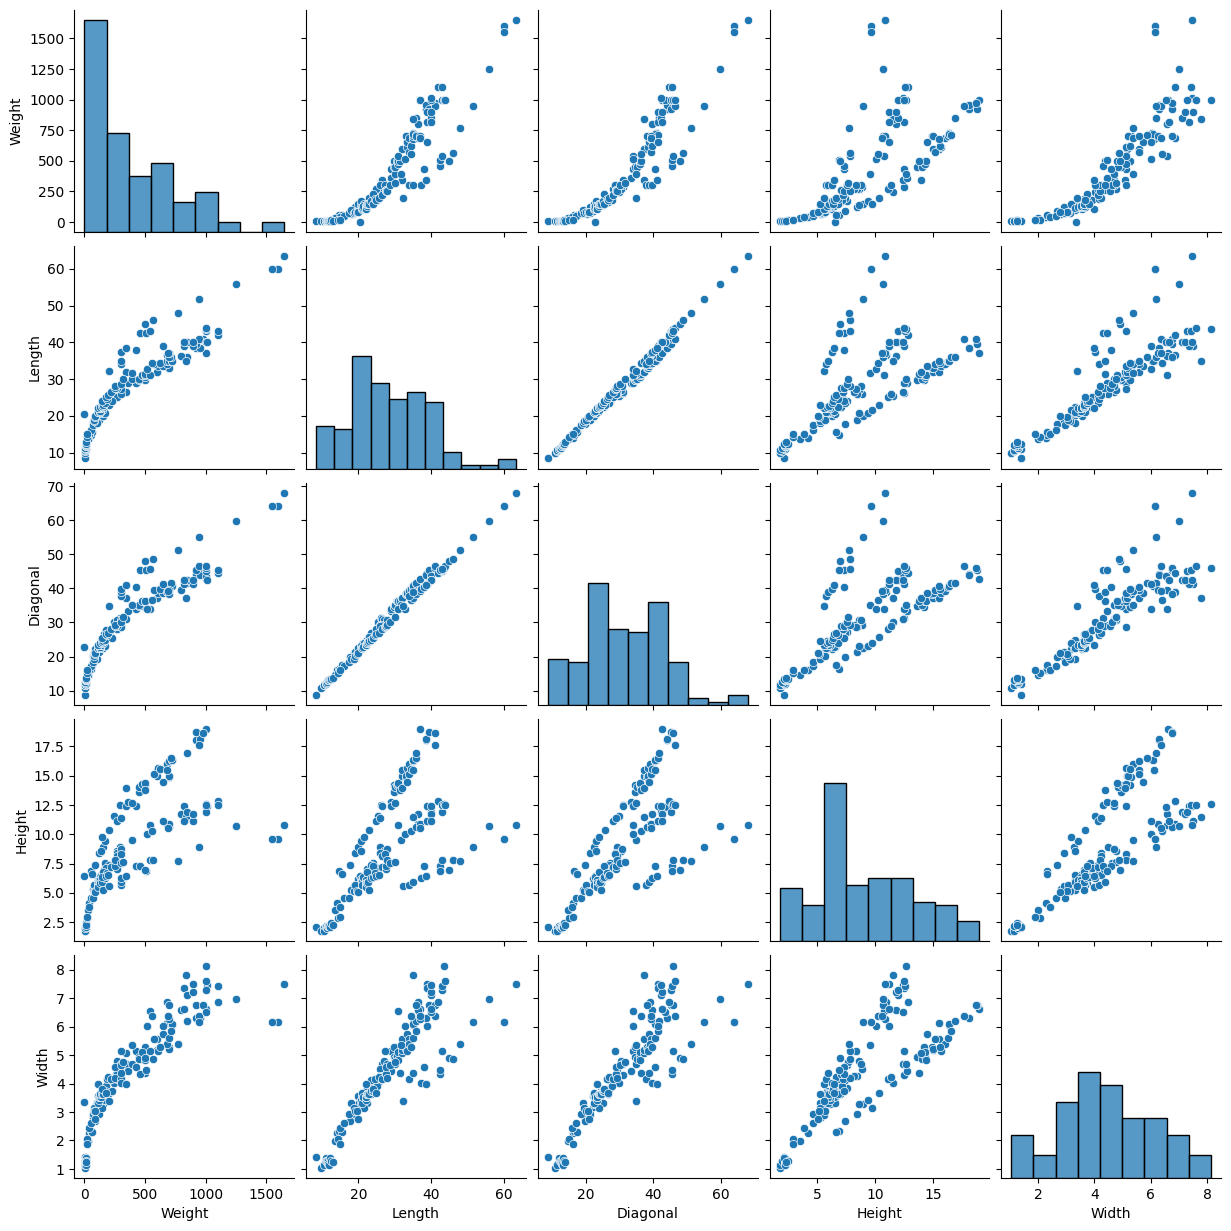

In [ ]:
sns.pairplot(data=fish_df)
plt.show()

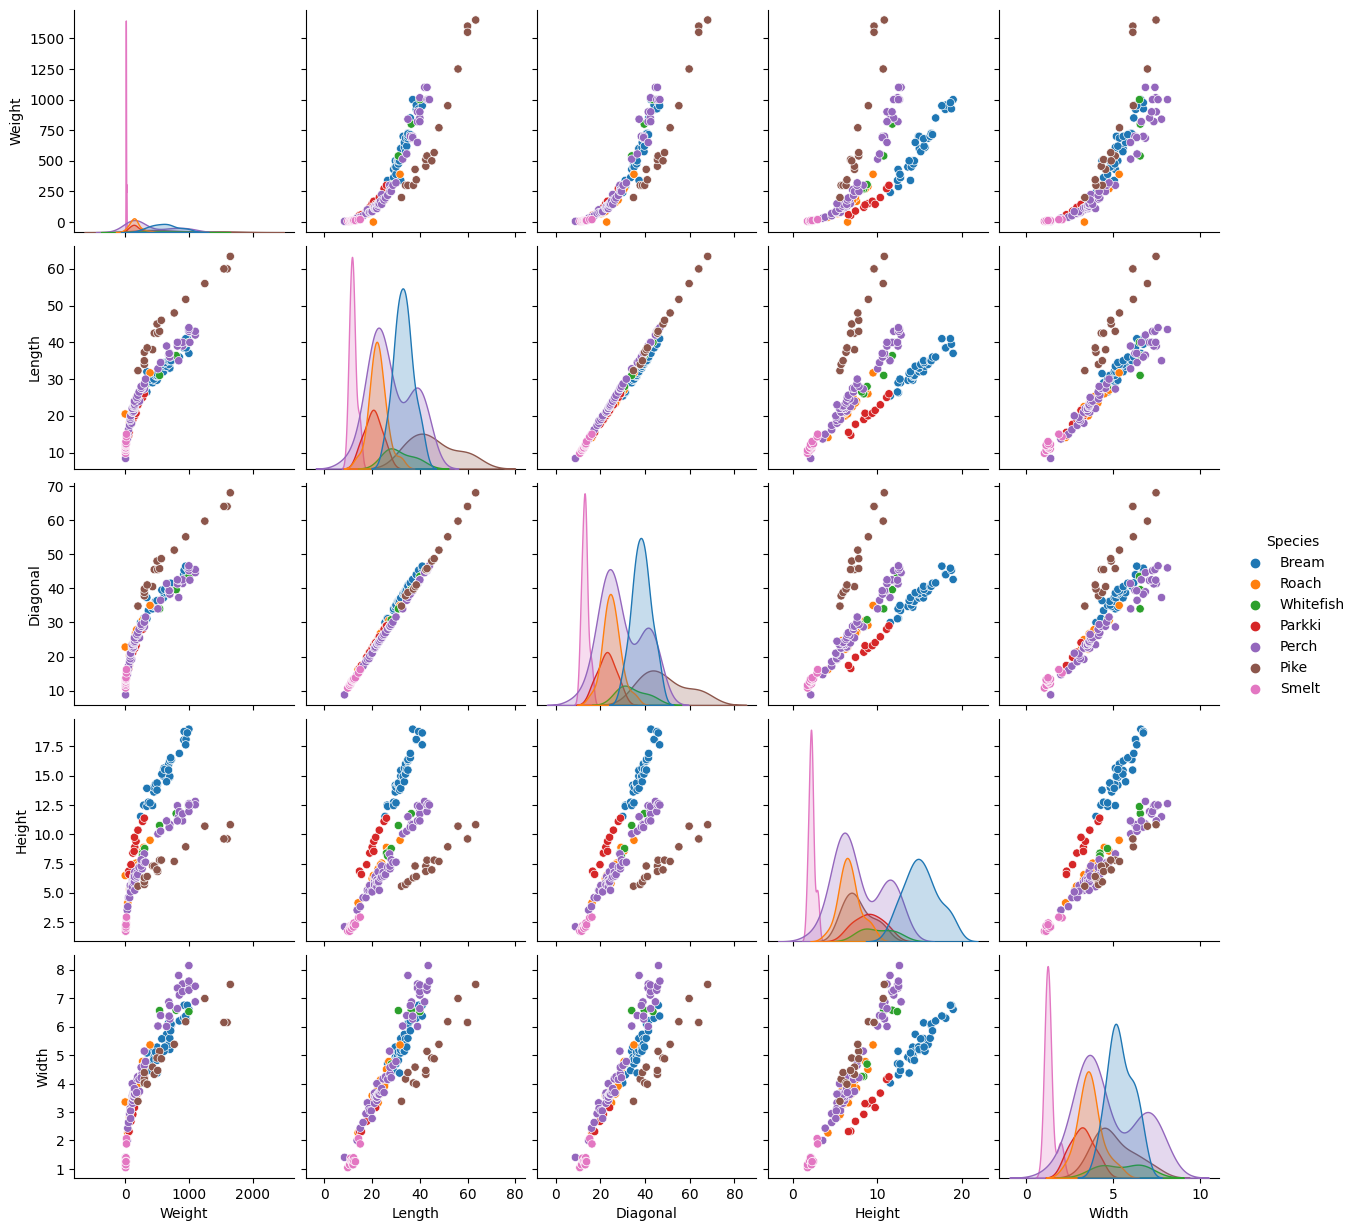

In [ ]:
sns.pairplot(data=fish_df, hue='Species')
plt.show()

# 문제정의

* 이진 분류(binary classification): Bream(도미), Smelt(빙어) 분류 문제.
* 독립 변수 선택: Weight(무게), Length(길이)

In [ ]:
# 머신 러닝에서 사용할 데이터프레임:
df = fish_df[(fish_df.Species == 'Bream') | (fish_df.Species == 'Smelt')][['Species', 'Weight', 'Length']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 158
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  49 non-null     object 
 1   Weight   49 non-null     float64
 2   Length   49 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.5+ KB


In [ ]:
df.head()

,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5
3,Bream,363.0,29.0
4,Bream,430.0,29.0


In [ ]:
df.Species.unique()

array(['Bream', 'Smelt'], dtype=object)

In [ ]:
df.Species.value_counts()

Bream    35
Smelt    14
Name: Species, dtype: int64

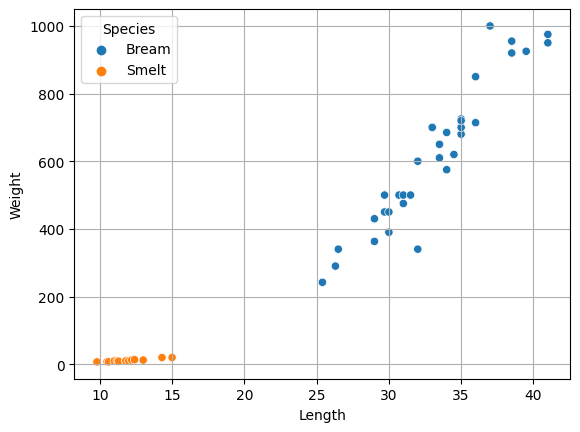

In [ ]:
sns.scatterplot(data=df, x='Length', y='Weight', hue='Species')
plt.grid()
plt.show()

* scikit-learn 패키지는 머신 러닝 알고리즘을 훈련시킬 때, 데이터(특성)와 레이블(타겟)을 구분해서 사용.
* 특성 배열은 2차원 배열. 타겟 배열은 1차원 배열.
* 도미-빙어 2진 분류 문제
  * 특성 배열: Weight, Length를 컬럼으로 갖는 2차원 배열
  * 타겟 배열: Species만을 갖는 1차원 배열

In [ ]:
# 특성 배열의 shape: (n_samples, n_features), (샘플 개수, 특성 개수)
X = df[['Weight', 'Length']].values

# 타겟 배열의 shape: (n_samples,)
y = df['Species'].values

In [ ]:
print(X.shape)  # (49, 2)
print(y.shape)  # (49,)

(49, 2)
(49,)


In [ ]:
X[:5]  # 특성 배열에서 첫 5개 샘플

array([[242. ,  25.4],
       [290. ,  26.3],
       [340. ,  26.5],
       [363. ,  29. ],
       [430. ,  29. ]])

In [ ]:
y[:5]  # 타겟 배열에서 첫 5개 샘플

array(['Bream', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

In [ ]:
X[-5:]  # 특성 배열에서 마지막 5개 샘플

array([[12.2, 12.2],
       [13.4, 12.4],
       [12.2, 13. ],
       [19.7, 14.3],
       [19.9, 15. ]])

In [ ]:
y[-5:]  # 타겟 배열에서 마지막 5개 샘플

array(['Smelt', 'Smelt', 'Smelt', 'Smelt', 'Smelt'], dtype=object)

# 머신 러닝 모델 선택

## KNN(K-Nearest Neighbors, k-최근접 이웃) 분류(classification) 알고리즘

* k개의 가장 가까운 이웃들의 레이블을 사용해서 예측(분류)하는 머신 러닝 모델.
* KNN 모델(알고리즘)은 별도의 훈련(학습) 시간이 필요하지 않음.
* KNN은 예측을 할 때 훈련 데이터와 테스트 데이터 사이의 거리들을 계산한 후 가장 가까운 이웃(거리) k를 찾음.
 * 예측 시간이 오래 걸릴 수 있음.
 * 이런 이유로 KNN을 "게으른 알고리즘(lazy algorithm)"이라고 부름.

## 머신 러닝 모델 객체 생성


In [ ]:
knn = KNeighborsClassifier()
# n_neighbors 파라미터: 기본값 5. KNN 알고리즘에서 사용할 가장 가까운 이웃 개수.

## 머신 러닝 모델 훈련(train)
데이터를 학습(learn)

In [ ]:
knn.fit(X, y)
#> 지도 학습(supervised learning): 머신 러닝 모델에게 특성과 레이블을 모두 제공하고 훈련(학습).

KNeighborsClassifier()

KNeighborsClassifier()
In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.
훈련 셋에서의 학습 결과 평가

In [ ]:
# 훈련 셋의 예측값을 계산.
y_pred = knn.predict(X)

In [ ]:
print(y_pred)  # KNN 모델의 예측값 출력

['Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt'
 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt'
 'Smelt' 'Smelt' 'Smelt' 'Smelt']


In [ ]:
print(y) # 실젯값 출력

['Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt'
 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt' 'Smelt'
 'Smelt' 'Smelt' 'Smelt' 'Smelt']


In [ ]:
y == y_pred  # 실젯값(타겟)과 예측값이 같은 지 다른 지 비교

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [ ]:
np.mean(y == y_pred)  # 정확도(accuracy)

1.0

## 가상의 물고기 테스트 데이터의 예측값
(600g, 30cm), (50g, 14cm) 물고기

In [ ]:
X_test = np.array([
    [600, 30],
    [50, 14]
])
print(X_test)

[[600  30]
 [ 50  14]]


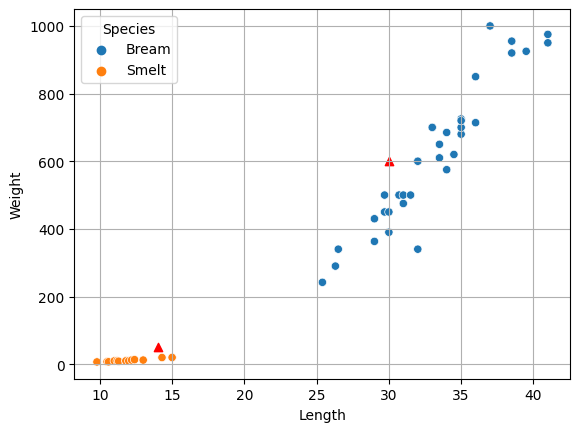

In [ ]:
# 훈련 셋 시각화
sns.scatterplot(data=df, x='Length', y='Weight', hue='Species')

# 가상 물고기 테스트 셋(X_test) 시각화
plt.scatter(x=X_test[:, 1], y=X_test[:, 0], c='red', marker='^')

plt.grid()
plt.show()

In [ ]:
y_test_pred = knn.predict(X_test)
print(y_test_pred)

['Bream' 'Smelt']


In [ ]:
neigh_dist, neigh_ind = knn.kneighbors(X_test)

In [ ]:
print(neigh_dist)  # 테스트 샘플에서 가장 가까운 거리 k(=5)개들의 배열

[[ 2.          2.         10.59481005 20.5        25.3179778 ]
 [30.11660671 30.30148511 36.63495598 37.8132252  37.84283287]]


In [ ]:
print(neigh_ind)  # 테스트 샘플에서 가장 가까운 이웃 k(=5)개의 인덱스

[[15 14 18 22 20]
 [48 47 45 46 44]]


In [ ]:
y[neigh_ind[0]]  # (600g, 30cm) 가상 물고기에서 가장 가까운 이웃 5개의 레이블

array(['Bream', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

In [ ]:
y[neigh_ind[1]]  # (50g, 14cm) 가상 물고기에서 가장 가까운 이웃 5개의 레이블

array(['Smelt', 'Smelt', 'Smelt', 'Smelt', 'Smelt'], dtype=object)

# KNN에서 k값에 따른 정확도 변화
* k값(n_neighbors)을 1 ~ 49까지 변화시키면서 KNN 분류 모델 객체를 생성:
* 생성된 KNN 모델을 X(특성 배열), y(타겟 배열)로 훈련.
* 훈련된 모델에서 훈련 셋(X)의 예측값, 정확도를 계산.
* k값에 따른 정확도 그래프(정확도 ~ k) 시각화.

In [ ]:
accuracies = []  # k값의 변화에 따른 KNN 모델의 정확도를 저장하기 위한 리스트
k_values = np.arange(1, 50)  # [1, 2, 3, ..., 48, 49]
for k in k_values:
    knn_clf = KNeighborsClassifier(n_neighbors=k)  # KNN 분류기 모델 생성
    knn_clf.fit(X, y)  # KNN 모델 훈련(데이터 학습)
    y_pred = knn_clf.predict(X)  # 훈련된 모델에서 훈련 셋의 예측값을 계산
    acc = np.mean(y == y_pred)  # 예측값의 정확도
    accuracies.append(acc)  # 리스트에 정확도를 추가

print(accuracies)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9795918367346939, 1.0, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.9795918367346939, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143]


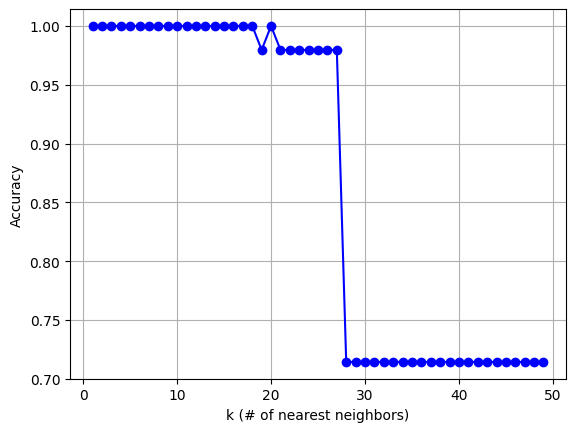

In [ ]:
plt.plot(k_values, accuracies, 'bo-')

plt.grid()
plt.xlabel('k (# of nearest neighbors)')
plt.ylabel('Accuracy')

plt.show()

# 훈련 셋, 테스트 셋 분리
훈련 셋과 테스트 셋을 나누는 방법:

* 순차 추출(sequential sampling)
* 임의 추출(random sampling)
* 층화 추출(stratified sampling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1,
                                                    stratify=y)

`train_test_split()` 함수 파라미터:

* X, y: 훈련 셋과 테스트 셋으로 나누려고 하는 배열들
* test_size: 테스트 셋의 샘플 개수 또는 비율.
   * test_size의 값이 정수이면, 테스트 샘플 개수.
   * test_size의 값이 0 ~ 1 사이의 실수이면, 테스트 샘플의 비율.
* train_size: 훈련 셋의 샘플 개수 또는 비율. test_size 값이 있으면 자동으로 계산됨.
* random_state: 난수를 생성하는 seed(np.random.seed(숫자)). 임의 추출 또는 층화 추출에서 샘플들을 섞기 위한 난수를 만들 때 사용.
* shuffle: 샘플을 랜덤하게 섞을 지를 설정.
   * True(기본값): 샘플들을 랜덤하게 섞음. 임의 추출.
   * False: 샘플들을 섞지 않음. 순차 추출.
* stratify: 층화 추출의 기준이 되는(각 클래스(카테고리)의 비율을 알 수 있는) 1차원 배열. 타겟 배열(레이블).

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34, 2), (15, 2), (34,), (15,))

In [ ]:
pd.value_counts(y_train)

Bream    24
Smelt    10
dtype: int64

In [ ]:
pd.value_counts(y_test)

Bream    11
Smelt     4
dtype: int64

# 훈련 셋과 훈련 레이블로 모델 학습

In [ ]:
# ML 모델 생성
knn = KNeighborsClassifier()

In [ ]:
# ML 모델을 훈련 타겟 배열과 훈련 타겟으로 훈련(학습)
knn.fit(X_train, y_train)

KNeighborsClassifier()

## KNeighborsClassifier()
```
In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.
```

In [ ]:
# 학습이 끝난 모델에서 훈련 셋의 예측값을 찾음.
y_train_pred = knn.predict(X_train)
print(y_train_pred)

['Smelt' 'Bream' 'Smelt' 'Bream' 'Smelt' 'Smelt' 'Bream' 'Smelt' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt' 'Smelt'
 'Bream' 'Smelt' 'Smelt' 'Bream' 'Bream' 'Bream' 'Bream']


In [ ]:
# 훈련 셋의 실젯값
print(y_train)

['Smelt' 'Bream' 'Smelt' 'Bream' 'Smelt' 'Smelt' 'Bream' 'Smelt' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Smelt' 'Smelt'
 'Bream' 'Smelt' 'Smelt' 'Bream' 'Bream' 'Bream' 'Bream']


In [ ]:
np.mean(y_train == y_train_pred)  # 훈련 셋에서의 정확도

1.0

In [ ]:
# 훈련되지 않은 테스트 셋의 예측값 찾음.
y_test_pred = knn.predict(X_test)
print(y_test_pred)

['Smelt' 'Smelt' 'Smelt' 'Bream' 'Bream' 'Bream' 'Smelt' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream']


In [ ]:
# 테스트 셋의 실젯값
print(y_test)

['Smelt' 'Smelt' 'Smelt' 'Bream' 'Bream' 'Bream' 'Smelt' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream']


In [ ]:
# 테스트 셋에서의 정확도
np.mean(y_test == y_test_pred)

1.0

## 분류 평가 지표(metrics)

## 오차 행렬, 혼동 행렬(confusion matrix)

In [ ]:
# 테스트 셋에서의 실제 레이블(타겟) - 도미(Bream, 11), 빙어(Smelt, 4)
y_test

array(['Smelt', 'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Smelt',
       'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream'], dtype=object)

In [ ]:
# 테스트 셋의 예측값
y_test_pred

array(['Smelt', 'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Smelt',
       'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream'], dtype=object)

In [ ]:
confusion_matrix(y_test, y_test_pred)

array([[11,  0],
       [ 0,  4]])

In [ ]:
cls_report = classification_report(y_test, y_test_pred)
print(cls_report)

              precision    recall  f1-score   support

       Bream       1.00      1.00      1.00        11
       Smelt       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



** 분류 평가 지표**

* 용어 정리

  * TP(True Positive, 진짜 양성): 실제 양성 샘플을 양성으로 맞게 예측한 것.
  * FN(False Negative, 가짜 음성): 실제 양섬 샘플을 음성으로 틀리게 예측한 것.
  * FP(False Positive, 가짜 양성): 실제 음성 샘플을 양성으로 틀리게 예측한 것.
  * TN(True Negative, 진짜 음성): 실제 음성 샘플을 음성으로 맞게 예측한 것.
* 정확도(accuracy): 샘플들을 정확하게 분류한 비율. 전체 샘플에서 정답의 비율.

accuracy = (TP + TN) / (TP + FN + FP + TN)

* 정밀도(precision): 양성 예측들 중에서 정답의 비율.
precision = TP / (TP + FP)

* 재현율(recall): 실제 양성 샘플들 중에서 정답의 비율.
recall = TP / (TP + FN)

* F1-score: 정밀도와 재현율의 조화 평균(역수들의 평균의 역수).
f1_score = 2 / (1/precision + 1/recall)

# 특성 스케일링(Feature Scaling)

변수들의 스케일 변환

In [ ]:
X_train[:5]

array([[  8.7,  11.3],
       [500. ,  29.7],
       [  9.9,  11.8],
       [850. ,  36. ],
       [  7. ,  10.6]])

In [ ]:
# 가상의 물고기 데이터: (150g, 25cm)
unknown = np.array([[150, 25]])

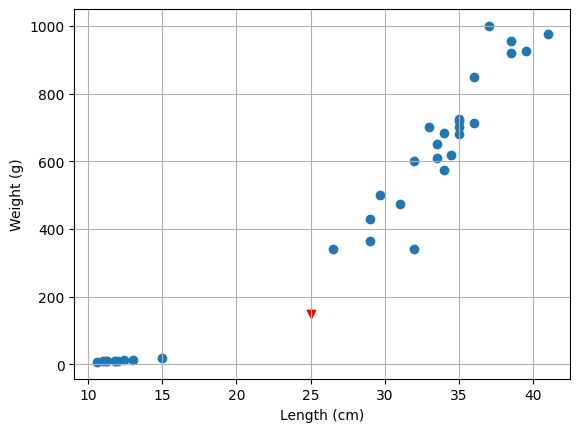

In [ ]:
# 훈련 셋(X_train) 시각화
plt.scatter(X_train[:, 1], X_train[:, 0])

# 가상의 물고기 시각화
plt.scatter(unknown[:, 1], unknown[:, 0], c='red', marker='v')

plt.xlabel('Length (cm)')
plt.ylabel('Weight (g)')
plt.grid()

plt.show()

In [ ]:
# Scale 변환을 하지 않은 훈련 셋으로 학습이 끝난 KNN 모델로 예측:
unknown_pred = knn.predict(unknown)
unknown_pred

array(['Smelt'], dtype=object)

In [ ]:
neigh_dist, neigh_ind = knn.kneighbors(unknown)

In [ ]:
neigh_dist  # 가장 가까운 이웃 5개 까지의 거리

array([[130.48375378, 137.17988191, 138.32150953, 140.62090883,
        140.72046759]])

In [ ]:
neigh_ind  # 가장 가까운 이웃 5개의 인덱스

array([[ 7,  5, 15, 26,  2]])

In [ ]:
y_train[neigh_ind]  # 가장 가까운 이웃 5개의 레이블

array([['Smelt', 'Smelt', 'Smelt', 'Smelt', 'Smelt']], dtype=object)

## 표준화 스케일링

* 훈련 셋에서 각 특성들의 평균과 표준편차를 찾아서, 평균이 0이 되고 표준편차가 1이 되도록 특석들의 스케일을 변환하는 방법.
* ★★★테스트 셋에서 스케일 변환을 할 때는, 훈련셋에서 찾은 평균과 표준편차를 사용해서 스케일링을 한다.★★★
* 스케일 변환 순서:
  1. 스케일러 객체 생성: `scaler = StandardScaler()`
  1. 훈련셋 스케일 변환(두가지 방법):
    * `scaler.fit(X_train)` --> `scaler.transform(X_train)` 메서드를 나눠서 호출하는 방법
    * `scaler.fit_transform(X_train)`
  1. 테스트 셋 스케일 변환:
    * `scaler.transform(X_test)`


In [ ]:
# 표준화 스케일러 객체 생성
scaler = StandardScaler()

In [ ]:
# 스케일러 객체를 사용해서 훈련 셋의 스케일을 변환
# fit(): X_train에서 특성들의 평균과 표준편차를 찾음.
# transform(): 특성들의 스케일을 변환.
X_tr_scaled = scaler.fit_transform(X_train)

In [ ]:
X_tr_scaled[:5]

array([[-1.36670716, -1.55381172],
       [ 0.07214866,  0.20050088],
       [-1.36319275, -1.50614018],
       [ 1.09718333,  0.80116226],
       [-1.3716859 , -1.62055187]])

In [ ]:
# unknown 배열을 스케일 변환:
unknown_scaled = scaler.transform(unknown)
unknown_scaled

array([[-0.95288602, -0.24761158]])

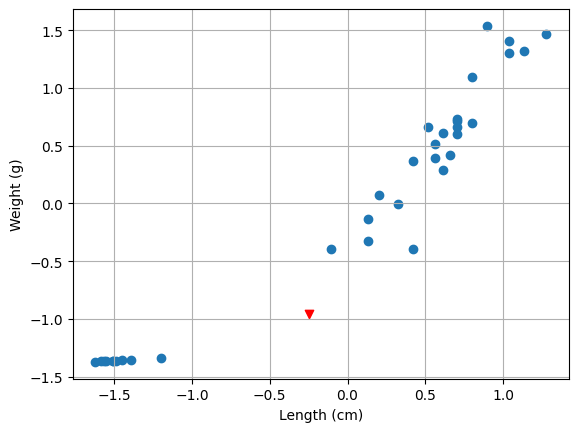

In [ ]:
# 스케일 변환된 훈련 셋(X_train) 시각화
plt.scatter(X_tr_scaled[:, 1], X_tr_scaled[:, 0], label = 'Train set')

# 스케일 변환된 가상의 물고기 시각화
plt.scatter(unknown_scaled[:, 1], unknown_scaled[:, 0], c='red', marker='v', label = 'unknown')

plt.xlabel('Length (cm)')
plt.ylabel('Weight (g)')
plt.grid()

plt.show()

In [ ]:
# KNN ML 모델 생성
Knn = KNeighborsClassifier()

In [ ]:
# 스케일 변환된 훈련 셋으로 모델을 학습시킴
knn.fit(X_tr_scaled, y_train)

KNeighborsClassifier()

In [ ]:
# 스케일 변환된 unknown 물고기의 예측값 계산:
unknown_pred = knn.predict(unknown_scaled)
unknown_pred

array(['Bream'], dtype=object)

In [ ]:
neigh_dist, neigh_ind = knn.kneighbors(unknown_scaled)

In [ ]:
neigh_dist

array([[0.57453188, 0.73114963, 0.86894103, 0.90437289, 1.02674558]])

In [ ]:
neigh_ind

array([[20, 13, 11, 23,  7]])

In [ ]:
y_train[neigh_ind[0]]

array(['Bream', 'Bream', 'Bream', 'Bream', 'Smelt'], dtype=object)

In [ ]:
# 스케일 변환된 훈련 셋에서 예측값:
y_train_pred = knn.predict(X_tr_scaled)
y_train_pred

array(['Smelt', 'Bream', 'Smelt', 'Bream', 'Smelt', 'Smelt', 'Bream',
       'Smelt', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream', 'Smelt', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream', 'Bream', 'Bream', 'Bream', 'Smelt', 'Smelt', 'Bream',
       'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

In [ ]:
y_train # 실제값(실제 레이블)

array(['Smelt', 'Bream', 'Smelt', 'Bream', 'Smelt', 'Smelt', 'Bream',
       'Smelt', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream', 'Smelt', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream', 'Bream', 'Bream', 'Bream', 'Smelt', 'Smelt', 'Bream',
       'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

In [ ]:
# 훈련셋에서의 정확도 출력
np.mean(y_train == y_train_pred)

1.0

In [ ]:
accuracy_score(y_train, y_train_pred)

1.0

In [ ]:
# 훈련 셋에서 찾은 평균과 표준편차를 사용해서 테스트 셋의 특성 스케일을 변환.
X_te_scaled = scaler.transform(X_test)
X_te_scaled[:5]

array([[-1.3725645 , -1.69682633],
       [-1.33449178, -1.26778249],
       [-1.37022156, -1.63008618],
       [ 0.36501571,  0.41978996],
       [ 0.07214866,  0.37211842]])

In [ ]:
# 스케일 변환된 테스트 셋에서 예측값:
y_test_pred = knn.predict(X_te_scaled)
y_test_pred

array(['Smelt', 'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Smelt',
       'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream'], dtype=object)

In [ ]:
y_test # 실제값(실제 레이블)

array(['Smelt', 'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Smelt',
       'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream'], dtype=object)

In [ ]:
# 테스트 셋에서의 정확도
accuracy_score(y_test, y_test_pred)

1.0

## Min-Max Scaling, Normalization(정규화)

* 훈련 셋의 최솟값과 최댓값을 찾아서, 훈련 셋이 최솟값이 0이 되도록, 최댓값이 1이 되도록 스케일을 변환.
* 훈련 셋에서 찾은 최솟값과 최댓값을 사용해서 테스트 셋도 스케일 변환.

1. MinMaxScaler 객체를 생성
1. 훈련 셋(X_train)을 Min-Max scale 변환.
1. 테스트 셋(X_test)을 Min-Max scale 변환.
1. KNN 모델을 생성
1. 스케일 변환된 훈련 셋으로 KNN 모델을 학습시킴
1. 훈련 셋의 예측 값을 찾고, 정확도를 계산
1. 테스트 셋의 예측 값을 찾고, 정확도를 계산
1. 테스트 셋의 예측 값을 찾고, 정확도를 계산

In [ ]:
scaler = MinMaxScaler() # 1.

In [ ]:
X_tr_scaled = scaler.fit_transform(X_train) # 2.

In [ ]:
X_te_scaled = scaler.transform(X_test) # 3.

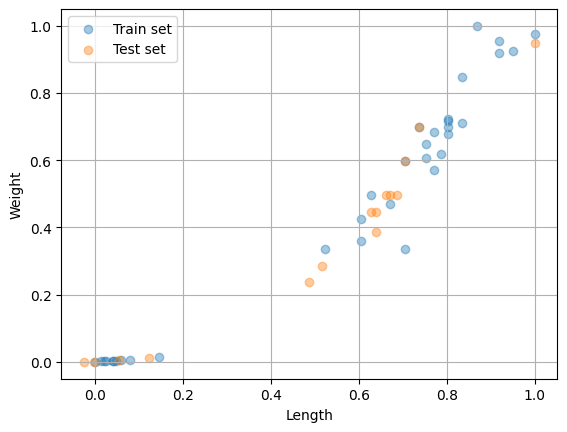

In [ ]:
# 스케일 변환된 훈련 셋 시각화
plt.scatter(x=X_tr_scaled[:, 1], y=X_tr_scaled[:, 0], alpha=0.4, label='Train set')

# 스케일 변환된 테스트셋을 그래프에 시각화
plt.scatter(x=X_te_scaled[:, 1], y=X_te_scaled[:, 0], alpha=0.4, label='Test set')

plt.legend()
plt.grid()
plt.xlabel('Length')
plt.ylabel('Weight')

plt.show()

In [ ]:
knn = KNeighborsClassifier() # 5.

In [ ]:
knn.fit(X_tr_scaled, y_train) # 6.

KNeighborsClassifier()

In [ ]:
y_train_pred = knn.predict(X_tr_scaled) # 7.
accuracy_score(y_train, y_train_pred) # 훈련 셋에서의 정확도

1.0

In [ ]:
y_test_pred = knn.predict(X_te_scaled) # 8.
accuracy_score(y_test, y_test_pred) # 테스트 셋에서의 정확도

1.0